<a href="https://colab.research.google.com/github/ANFAL23/arabicthon_back/blob/main/lexical_field_and_vizualisation_wikiar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyarabic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 3.9 MB/s eta 0:00:00


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Multiply, concatenate
from keras.layers import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

import keras

import urllib.request
import collections
import os
import zipfile

import numpy as np
import tensorflow as tf
from pyarabic import araby


In [ ]:
!wget https://raw.githubusercontent.com/zaidalyafeai/ARBML/master/datasets/Wiki/wiki_ar.txt
wiki_path = 'wiki_ar.txt'


--2023-11-15 21:22:30--  https://raw.githubusercontent.com/zaidalyafeai/ARBML/master/datasets/Wiki/wiki_ar.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59054425 (56M) [text/plain]
Saving to: ‘wiki_ar.txt’

wiki_ar.txt         100%[===================>]  56.32M   272MB/s    in 0.2s    

2023-11-15 21:22:32 (272 MB/s) - ‘wiki_ar.txt’ saved [59054425/59054425]



In [ ]:
import nltk
nltk.download('stopwords')
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))

remove_as_well = set(['ان', 'او', 'ا', 'لا', 'في', 'على', 'الى', 'اي', 'م', 'تكون', 'كان', 'من', 'اذا', 'مع'])
arb_stopwords |= remove_as_well

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Read the data into a list of strings.
def read_data(filename):
    with open(filename, 'r') as f:
      corpus = f.read()
      corpus = corpus.replace('\n',' ')
      corpus = araby.strip_tashkeel(corpus)
    return corpus.split()


def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        if word not in arb_stopwords:
          dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def collect_data(vocabulary_size=10000):
    vocabulary = read_data(wiki_path)
    print(vocabulary[:7])
    data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                                vocabulary_size)
    del vocabulary  # Hint to reduce memory.
    return data, count, dictionary, reverse_dictionary

In [ ]:
vocab_size = 10000
data, count, dictionary, reverse_dictionary = collect_data(vocabulary_size=vocab_size)
print(data[:7])
print(len(data))
vocab_size = len(dictionary)

['الماء', 'هو', 'مادة', 'شفافة', 'عديمة', 'اللون', 'والرائحة']
[259, 0, 931, 0, 0, 2042, 0]
5364230


In [ ]:
#setup parameters
window_size = 3
vector_dim = 256

#sample data according to the window size
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(data, vocab_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)

word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[9651, 3354], [566, 4893], [705, 5893], [6177, 6553], [1576, 5841], [1989, 6350], [4605, 5318], [6295, 4914], [4138, 81], [5564, 29]] [1, 1, 1, 1, 0, 0, 0, 0, 1, 1]


In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Multiply, Embedding
from keras.layers import Dot

# Assuming you have defined vocab_size and vector_dim

# Create some input variables with a batch dimension
input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')
target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# Setup a cosine similarity operation which will be output in a secondary model
similarity = Dot(axes=1, normalize=True)([target, context])

# Now perform the dot product operation to get a similarity measure
dot_product = Dot(axes=1)([target, context])

dot_product = Reshape((1,))(dot_product)

# Add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

# Create the primary training model
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

# Create a secondary validation model to run similarity checks during training
validation_model = Model(inputs=[input_target, input_context], outputs=similarity)


In [ ]:
similarity.shape

TensorShape([None, 1, 1])

In [ ]:
dictionary.keys()

dict_keys(['UNK', 'عام', '،', 'بن', 'كانت', 'وقد', 'سنة', 'وفي', 'عبد', 'الله', 'خلال', 'وهي', 'مدينة', 'وكان', 'تم', 'عدد', 'المدينة', 'محمد', 'القرن', 'أنه', 'الدولة', '%', 'والتي', 'العالم', 'الدين', 'يمكن', 'بشكل', 'العربية', 'المتحدة', 'الأول', 'فقد', 'أخرى', 'العديد', 'الحرب', 'ابن', 'هـ', 'منطقة', 'حوالي', 'علي', 'أكبر', 'البلاد', 'عندما', 'الملك', 'الثاني', 'وذلك', 'مصر', 'عليها', 'اللغة', 'يكون', 'يتم', 'وكانت', 'أنها', 'الأولى', 'حول', 'عدة', 'المنطقة', 'طريق', 'بسبب', 'باسم', 'م،', 'اسم', 'العام', 'الدول', 'السلطان', 'يوم', 'قال', 'الحكومة', '–', 'الجيش', 'كبير', 'الولايات', 'نظام', 'الأخرى', 'السكان', 'الأرض', 'دولة', 'مليون', 'بأن', 'البحر', 'فترة', 'ضد', 'ولم', 'الوقت', 'معظم', 'أحمد', 'رئيس', 'المناطق', 'كبيرة', 'الفترة', 'آخر', 'بالإضافة', 'اليوم', 'وبعد', 'الاتحاد', 'مجموعة', 'جنوب', 'العالمية', 'سكان', 'بينما', 'أهم', 'القوات', 'العربي', 'فقط', 'وعلى', 'الحكم', 'الثانية', 'وجود', 'أوروبا', 'عبر', 'أبي', 'درجة', 'القديمة', 'تقع', 'ولاية', 'نسبة', 'الرغم', 'الناس', 'الم

In [ ]:
valid_examples = np.array([dictionary[text] for text in ['الحج', 'حافظ', 'البرمجة']])
valid_size = len(valid_examples)

In [ ]:
valid_size

3

In [ ]:
class SimilarityCallback:
    def run_sim(self):
        for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8  # number of nearest neighbors
            sim = self._get_sim(valid_examples[i])
            nearest = (-sim).argsort()[1:top_k + 1]
            log_str = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = '%s %s,' % (log_str, close_word)
            print(log_str)

    @staticmethod
    def _get_sim(valid_word_idx):
        sim = np.zeros((vocab_size,))
        in_arr1 = np.zeros((1,))
        in_arr2 = np.zeros((1,))
        in_arr1[0,] = valid_word_idx
        for i in range(vocab_size):
            in_arr2[0,] = i
            out = validation_model.predict_on_batch([in_arr1, in_arr2])
            sim[i] = out
        return sim
sim_cb = SimilarityCallback()

In [ ]:
print(dictionary.keys())

dict_keys(['UNK', 'عام', '،', 'بن', 'كانت', 'وقد', 'سنة', 'وفي', 'عبد', 'الله', 'خلال', 'وهي', 'مدينة', 'وكان', 'تم', 'عدد', 'المدينة', 'محمد', 'القرن', 'أنه', 'الدولة', '%', 'والتي', 'العالم', 'الدين', 'يمكن', 'بشكل', 'العربية', 'المتحدة', 'الأول', 'فقد', 'أخرى', 'العديد', 'الحرب', 'ابن', 'هـ', 'منطقة', 'حوالي', 'علي', 'أكبر', 'البلاد', 'عندما', 'الملك', 'الثاني', 'وذلك', 'مصر', 'عليها', 'اللغة', 'يكون', 'يتم', 'وكانت', 'أنها', 'الأولى', 'حول', 'عدة', 'المنطقة', 'طريق', 'بسبب', 'باسم', 'م،', 'اسم', 'العام', 'الدول', 'السلطان', 'يوم', 'قال', 'الحكومة', '–', 'الجيش', 'كبير', 'الولايات', 'نظام', 'الأخرى', 'السكان', 'الأرض', 'دولة', 'مليون', 'بأن', 'البحر', 'فترة', 'ضد', 'ولم', 'الوقت', 'معظم', 'أحمد', 'رئيس', 'المناطق', 'كبيرة', 'الفترة', 'آخر', 'بالإضافة', 'اليوم', 'وبعد', 'الاتحاد', 'مجموعة', 'جنوب', 'العالمية', 'سكان', 'بينما', 'أهم', 'القوات', 'العربي', 'فقط', 'وعلى', 'الحكم', 'الثانية', 'وجود', 'أوروبا', 'عبر', 'أبي', 'درجة', 'القديمة', 'تقع', 'ولاية', 'نسبة', 'الرغم', 'الناس', 'الم

In [ ]:
import numpy as np

def get_batch(idx, word_target, word_context, labels, batch_size=32):
    start_idx = idx * batch_size
    end_idx = (idx + 1) * batch_size

    arr_1 = np.array(word_target[start_idx:end_idx])
    arr_2 = np.array(word_context[start_idx:end_idx])
    arr_3 = np.array(labels[start_idx:end_idx])

    return arr_1, arr_2, arr_3

In [ ]:
batch_size = 256
avg_loss = 0.0
epochs = 10
for cnt in range(epochs):
    num_batches = len(labels)// batch_size

    for idx in range(0, num_batches):
      batch_idx = np.random.randint(0, num_batches)
      arr_1, arr_2, arr_3  = get_batch(batch_idx, word_target, word_context, labels, batch_size = batch_size)
      loss = model.train_on_batch([arr_1, arr_2], arr_3)
      avg_loss += loss

      if idx % 1000 == 0 and idx != 0:
        print("Iteration {}, loss={}".format(cnt, avg_loss/1000))
        avg_loss = 0.0
      if idx % 10000 == 0:
        sim_cb.run_sim()
        print(" ")


Nearest to الحج: الصوم, وهي, الجمعة, لأداء, الإسلام, لكثرة, تاريخ, مكة,
Nearest to حافظ: الأسد, خالد, الحليم, للرئيس, بن, بهاء, الرئيس, يرى,
Nearest to البرمجة: لغات, أداة, إتش, برمجة, باستخدام, بواسطة, برامج, أدوات,
 
Iteration 0, loss=0.320279769860208
Iteration 0, loss=0.3123187301941216
Iteration 0, loss=0.30985431460663676
Iteration 0, loss=0.30565152306109666
Iteration 0, loss=0.3018425003364682
Iteration 0, loss=0.30053663294017313
Iteration 0, loss=0.2970971082299948
Iteration 0, loss=0.28437156799435614
Iteration 0, loss=0.28826038075238464
Iteration 0, loss=0.2818985806107521
Nearest to الحج: الجمعة, الصوم, صلاة, لأداء, أمور, ومصر،, الإسلام, الصلاة,
Nearest to حافظ: المغرب, حسين, بن, الحليم, بدور, حسن, الأسد, اللواء,
Nearest to البرمجة: لغات, برمجة, تصف, إتش, المعلومات, الأصوات, نسخ, المختلفة,
 
Iteration 0, loss=0.27468356567248703
Iteration 0, loss=0.27377884097024796
Iteration 0, loss=0.278239714153111
Iteration 0, loss=0.26096411108225587
Iteration 0, loss=0.2667411624006

In [ ]:
# Saving model
model.save('word_similarity_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  `tf.saved_model.SaveOptions` object that specifies SavedModel


In [ ]:
def find_top_k(word, top_k = 8):
    valid_word_idx = dictionary[word]
    sim = get_similar(valid_word_idx)
    nearest = (-sim).argsort()[1:top_k + 1]
    log_str = word + ':'
    for k in range(top_k):
        close_word = reverse_dictionary[nearest[k]]
        log_str = '%s  %s -' % (log_str, close_word)
    print(log_str)

def get_similar(valid_word_idx):
    sim = np.zeros((vocab_size,))
    in_arr1 = np.zeros((1,))
    in_arr2 = np.zeros((1,))
    in_arr1 = np.array([valid_word_idx]*vocab_size)
    in_arr2 = np.array(range(vocab_size))
    out = validation_model.predict_on_batch([in_arr1, in_arr2])
    out = out.reshape((vocab_size,))

    return out

In [ ]:
find_top_k('الحب')

الحب:  عيد -  امرأة -  اليد -  شراء -  السفلي -  يلي -  عادة -  العالم -


# **Active Learning**

The scenario we are going to described is a form of interactive learning or online learning in the context of Natural Language Processing (NLP). Specifically, it involves a feedback loop where user-provided information (in the form of responses to word similarity questions) is used to continuously update and improve the NLP model.

Here's a breakdown of the key components:

1. **Interactive Learning:** The system interacts with the user by presenting word similarity questions (e.g., asking if two words are synonyms) and collects user feedback.

2. **Adaptation or Fine-Tuning:** The NLP model is updated or fine-tuned based on the user's responses. When the user provides feedback (e.g., by answering "yes" or "no" to a synonym question), the model is adjusted to better reflect the user's input.

3. **Word Similarity Calculation:** The underlying NLP algorithm is likely using techniques such as word embeddings or other methods to calculate word similarity. The model is modified over time based on user feedback to improve its accuracy in capturing semantic relationships between words.


In [ ]:
from keras.layers import Input, Dense, Reshape, Embedding, Dot
import numpy as np
from keras.models import load_model

# Load the model from the file
#loaded_model = load_model('word_similarity_model.h5')


def get_user_feedback(word1, word2):
    # Simulate user interaction, replace this with your actual user input mechanism
    user_input = input(f"Is '{word1}' a synonym of '{word2}'? (yes/no): ").lower()
    return user_input == 'yes'

def update_model_with_feedback(model, target_word, context_word, is_synonym):
    target_idx = dictionary.get(target_word, 0)
    context_idx = dictionary.get(context_word, 0)
    target_array = np.array([target_idx])
    context_array = np.array([context_idx])
    label = np.array([1]) if is_synonym else np.array([0])

    model.train_on_batch([target_array, context_array], label)

# Example of using user feedback to update the model
target_word = 'الحج'
context_word = 'المكة'
is_synonym = get_user_feedback(target_word, context_word)

# Update the model based on user feedback
update_model_with_feedback(model, target_word, context_word, is_synonym)

# After updating the model, you might want to run similarity checks
sim_cb = SimilarityCallback()

Is 'الحج' a synonym of 'المكة'? (yes/no): yes


# **WordCloud**

In [ ]:
!pip install wordcloud

   Word SimilarWords  CosineScores
0   مكة      المكرمة      0.413996
1   مكة       القرية      0.319735
2   مكة       الرياض      0.316268
3   مكة      المنورة      0.310011
4   مكة         قضاء      0.302436
5   مكة      العائلة      0.297481
6   مكة         يقطع      0.294366
7   مكة       الحجاج      0.290340
8   مكة           هـ      0.279773
9   مكة         جيجل      0.276974
10  مكة      الخرطوم      0.274983
11  مكة          دار      0.272008
12  مكة     كيلومترا      0.271423
13  مكة        حوالي      0.270505
14  مكة       البصرة      0.269827
15  مكة        الشام      0.268929
16  مكة       الطائف      0.267723
17  مكة         وقبل      0.267543
18  مكة         الله      0.266618
19  مكة        أسوان      0.266377
20  مكة        البيت      0.265484
21  مكة       مستشفى      0.260933
22  مكة          جدة      0.260800
23  مكة         بنقل      0.256960
24  مكة       الحجاز      0.255967
25  مكة      المناطق      0.255201
26  مكة          لأن      0.255107
27  مكة     المدينة،

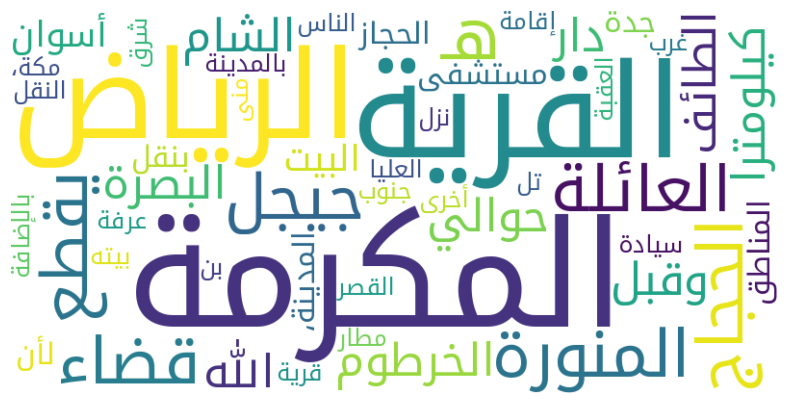

In [ ]:
def find_top_k(word, top_k=8):
    valid_word_idx = dictionary[word]
    sim = get_similar(valid_word_idx)
    nearest = (-sim).argsort()[1:top_k + 1]

    results = {'Word': word, 'SimilarWords': [], 'CosineScores': []}

    for k in range(top_k):
        close_word = reverse_dictionary[nearest[k]]
        cosine_score = sim[nearest[k]]

        results['SimilarWords'].append(close_word)
        results['CosineScores'].append(cosine_score)

    # Display the results in a DataFrame
    df_results = pd.DataFrame(results)
    print(df_results)

    arabic_font_path = "NotoKufiArabic-VariableFont_wght.ttf"
    arabic_font = {"font_path": arabic_font_path, "width": 800, "height": 400, "background_color": 'white'}

    # Create a WordCloud
    wordcloud = WordCloud(**arabic_font).generate_from_frequencies(
        dict(zip(df_results['SimilarWords'], df_results['CosineScores']))
    )

    # Display the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def get_similar(valid_word_idx):
    sim = np.zeros((vocab_size,))
    in_arr1 = np.zeros((1,))
    in_arr2 = np.zeros((1,))
    in_arr1 = np.array([valid_word_idx] * vocab_size)
    in_arr2 = np.array(range(vocab_size))
    out = validation_model.predict_on_batch([in_arr1, in_arr2])
    out = out.reshape((vocab_size,))

    return out

# Example usage
top = find_top_k('مكة', top_k=50)

# **3D Graph Network**

In [ ]:
import pandas as pd
import networkx as nx
import plotly.graph_objs as go
import plotly.offline as py
import random


# Assuming you have the `model` and `validation_model` already defined

def find_top_k(word, top_k=8):
    valid_word_idx = dictionary[word]
    sim = get_similar(valid_word_idx)
    nearest = (-sim).argsort()[1:top_k + 1]

    results = {'Word': word, 'SimilarWords': [], 'CosineScores': []}

    for k in range(top_k):
        close_word = reverse_dictionary[nearest[k]]
        cosine_score = sim[nearest[k]]

        results['SimilarWords'].append(close_word)
        results['CosineScores'].append(cosine_score)

    # Display the results in a DataFrame
    df_results = pd.DataFrame(results)
    print(df_results)

    return df_results


def create_3d_network(df_results):
    G = nx.Graph()

    for i, row in df_results.iterrows():
        G.add_node(row['Word'], size=random.randint(1, 10))

    for i, row in df_results.iterrows():
        scores = row['CosineScores']
        if not isinstance(scores, list):
            scores = [scores]
        for j, score in enumerate(scores):
            if score > 0.5:  # You can adjust the threshold as needed
                G.add_edge(row['Word'], row['SimilarWords'][j], weight=score)

    pos = nx.spring_layout(G, dim=3)

    edge_x = []
    edge_y = []
    edge_z = []
    for edge in G.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])

    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(color='rgb(125,125,125)', width=2),
    )

    node_x = [pos[word][0] for word in G.nodes()]
    node_y = [pos[word][1] for word in G.nodes()]
    node_z = [pos[word][2] for word in G.nodes()]

    node_trace = go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers+text',
        marker=dict(size=[G.nodes[word]['size'] * 10 for word in G.nodes()], color=[G.nodes[word]['size'] for word in G.nodes()], colorscale='Viridis', colorbar=dict(title='Frequency')),
        text=list(G.nodes()),  # Convert NodeView to a list of strings
        textposition='middle center',
        textfont=dict(size=10, color='black')
    )

    fig = go.Figure(data=[edge_trace, node_trace])

    fig.update_layout(title='شبكة العلاقات الدلالية ثلاثية الأبعاد', showlegend=False)

    py.iplot(fig)



# Example usage
data = find_top_k('مكة', top_k=8)


  Word SimilarWords  CosineScores
0  مكة      المكرمة      0.413996
1  مكة       القرية      0.319735
2  مكة       الرياض      0.316268
3  مكة      المنورة      0.310011
4  مكة         قضاء      0.302436
5  مكة      العائلة      0.297481
6  مكة         يقطع      0.294366
7  مكة       الحجاج      0.290340


In [ ]:
# Extract Arabic words and their frequencies from the CSV
arabic_words = data['SimilarWords'].tolist()
word_cosine = data.drop(columns=['Word'])  # Replace random frequencies with actual frequencies


In [ ]:
word_cosine

,SimilarWords,CosineScores
0,المكرمة,0.413996
1,القرية,0.319735
2,الرياض,0.316268
3,المنورة,0.310011
4,قضاء,0.302436
5,العائلة,0.297481
6,يقطع,0.294366
7,الحجاج,0.290340


In [ ]:
import plotly.graph_objs as go
import plotly.offline as py
import networkx as nx

# Assuming word_cosine is a DataFrame with columns 'SimilarWords' and 'CosineScores'

# Create a graph
knowledge_graph = nx.Graph()

# Add nodes with their sizes and colors based on CosineScores
for index, row in word_cosine.iterrows():
    word = row['SimilarWords']
    score = row['CosineScores']
    knowledge_graph.add_node(word, size=score, color=score)

# Generate random edges to create connections
edges = []

# Randomly connect nodes to form edges
for node in word_cosine['SimilarWords']:
    num_edges = random.randint(3, 5)
    for _ in range(num_edges):
        connected_node = random.choice(word_cosine['SimilarWords'])
        if connected_node != node and (node, connected_node) not in edges and (connected_node, node) not in edges:
            edges.append((node, connected_node))

knowledge_graph.add_edges_from(edges)

# Position the nodes in a 3D layout
pos = nx.spring_layout(knowledge_graph, dim=3)

# Prepare the edges for visualization
edge_x = []
edge_y = []
edge_z = []
for edge in knowledge_graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(color='rgb(125,125,125)', width=2),
)

# Prepare the nodes for visualization with colorscale based on CosineScores
node_x = [pos[word][0] for word in knowledge_graph.nodes()]
node_y = [pos[word][1] for word in knowledge_graph.nodes()]
node_z = [pos[word][2] for word in knowledge_graph.nodes()]

node_trace = go.Scatter3d(
    x=node_x, y=node_y, z=node_z,
    mode='markers+text',
    marker=dict(size=[knowledge_graph.nodes[word]['size'] * 10 for word in knowledge_graph.nodes()],
                color=[knowledge_graph.nodes[word]['color'] for word in knowledge_graph.nodes()],
                colorscale='Viridis', colorbar=dict(title='CosineScores')),
    text=list(knowledge_graph.nodes()),
    textposition='middle center',
    textfont=dict(size=10, color='black')
)


# Create the 3D knowledge graph figure
fig = go.Figure(data=[edge_trace, node_trace])

# Set layout options
fig.update_layout(title='شبكة العلاقات الدلالية ثلاثية الأبعاد', showlegend=False)

# Show the 3D knowledge graph
py.iplot(fig)


In [ ]:
create_3d_network(df_results)